In [3]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle
import pylab
from scipy.stats import probplot,expon,kstest,norm
import matplotlib.pyplot as plt
import json
from datetime import timedelta
import pandas as pd
from scipy.stats.stats import pearsonr
import bisect
import scipy.stats as ss
import bisect
from mpl_toolkits.mplot3d import Axes3D

# Load Data

In [2]:
def parse_file_json(file_name):
    with open(file_name, "r") as f:
        data = [json.loads(line) for line in f]
    starting_time = parser.parse(data[0][0])
    starting_bids = data[0][1]
    starting_asks = data[0][2]
    
    raw_updates = data[1:]
    
    Bids = {}
    Asks = {}    
    
    updates = []
    
    for price, amount in starting_bids:
        Bids[int(round((float(price)*100)))] = float(amount)
    for price, amount in starting_asks:
        Asks[int(round((float(price)*100)))] = float(amount)
        
    for u in raw_updates:
        price = int(round((float(u["price"])*100)))  
        side = u["side"]
        amount = float(u["amount"])
        time = parser.parse(u["time"])
        
        if side == "buy":
            change = amount - Bids.get(price,0)
        else:
            change = amount - Asks.get(price,0)
        
        updates.append({\
            "Bids": copy.copy(Bids), \
            "Asks": copy.copy(Asks), \
            "time": time, \
            "side": side, \
            "price": price, \
            "change": change            
        })
        
        if side == "buy":
            if u["amount"] == "0":
                del Bids[price]
            else:
                Bids[price] = float(amount)
        else:
            if u["amount"] == "0":
                del Asks[price]
            else:
                Asks[price] = float(amount)   

    return(starting_time, updates)

In [3]:
def shortened_updates(file_name,K):
    starting_time, updates = parse_file_json(file_name)
    
    res = []
    
    # Caluclate first reference price
    starting_bids = updates[0]['Bids']
    starting_asks = updates[0]['Asks']
    sorted_bids = list(reversed(sorted(starting_bids.items())))
    sorted_asks = list(sorted(starting_asks.items()))        
    best_bid = sorted_bids[0][0]
    best_ask = sorted_asks[0][0]
    if ((best_bid + best_ask) % 2) != 0:
        old_reference_price = round((best_bid+best_ask)/2, 1)
    else:
        old_reference_price = round((best_bid+best_ask+1)/2, 1)
            
    for u in updates:      
        # Find reference price
        sorted_bids = list(reversed(sorted(u['Bids'].items())))
        sorted_asks = list(sorted(u['Asks'].items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if old_reference_price > middle:
                reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                old_reference_price = round((best_bid+best_ask)/2 - 0.5,1)
                
        shortened_book = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
        first_bid = int(round(reference_price - 0.5))
        first_ask = int(round(reference_price + 0.5))        
        for k in range(-K,0):
            shortened_book[k] = u['Bids'].get(first_bid + k + 1,0)
        for k in range(1,K+1):
            shortened_book[k] = u['Asks'].get(first_ask + k - 1,0)
            
        # Find k from the price. Keep track of event if
        # abs(k) <= K
        price = u["price"]
        k = price - reference_price
        if k < 0:
            k = int(round(k - 0.5))
        else:
            k = int(round(k + 0.5))
        if abs(k) <= K:                 
            res.append({
                'reference_price': reference_price,
                'LOB': copy.copy(shortened_book),
                'k': k,
                'change': u['change'],
                'time': u['time']
            })
        
        old_reference_price = reference_price

    return starting_time, res

# Combine Updates that Occur At Same Time

# Combine Orders that Occur in Quick Succession
### (Orders that occur within 0.01 seconds of each other)

In [4]:
def processed_updates(file_name,K):
    starting_time,updates = shortened_updates(file_name,10)
    grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
    # Contains dictionary of time, reference price, order book, list of changes
    cleaned_updates = []
    for t, us in grouped_by_time.items():
        if len(us) == 1:
            u = us[0]
            cleaned_updates.append(copy.copy(u))
        else:
            new_update = {'time': t}
            us = sorted(us, key=lambda u:-abs(u['k']))
            grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
            reference_k = list(grouped_by_k.keys())[0]
            new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
            new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
            events = []
            for k in grouped_by_k:
                combined_change = 0
                for u in grouped_by_k[k]:
                    combined_change = combined_change + u['change']
                events.append((k,combined_change))
            for k,change in events:
                new_update = copy.deepcopy(new_update)
                new_update['k'] = k
                new_update['change'] = change
                cleaned_updates.append(new_update)
    
    combined_updates = []
    i = 0
    while i < len(cleaned_updates):
        reference_price = cleaned_updates[i]['reference_price']
        j = i
        updates_at_reference = []
        while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
            updates_at_reference.append(cleaned_updates[j])
            j += 1
        updates_at_reference = sorted(updates_at_reference,key=lambda u:u['k'])
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(updates_at_reference, key=lambda u:u['k']))
        for k,us in grouped_by_k.items():
            us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
            keep_index = [True for u in us]
            for m in reversed(range(1,len(us))):
                quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
                same_sign = (us[m]['change'] * us[m-1]['change']) > 0
                if quick_same_order and same_sign:
                    us[m-1]['change'] += us[m]['change']
                    keep_index[m] = False
            for (u,keep) in zip(us, keep_index):
                if keep:
                    combined_updates.append(u)
        i = j + 1

    combined_updates = sorted(combined_updates,key=lambda u:u['time'])
    
    ending_time = combined_updates[-1]['time']
    
    return starting_time, ending_time, combined_updates

starting_time, ending_time, combined_updates = processed_updates('12_28_18.json',10)
len(combined_updates)

305806

In [5]:
starting_times, ending_times, time_period_updates = zip(*[processed_updates(f,10) for f in ['12_28_18.json','12_29_18.json','12_30_18.json']])

In [64]:
with open('processed_data.pkl', 'wb') as f:
    pickle.dump([starting_times, ending_times, time_period_updates], f)

# START HERE

In [4]:
with open('processed_data.pkl', 'rb') as f:
    starting_times, ending_times, all_updates = pickle.load(f)

In [5]:
all_update_times = []
for updates in all_updates:
    all_update_times.append([u['time'] for u in updates])

# Sample intervals

In [6]:
def updates_during_period(updates, update_times, start, end):
    left_index = bisect.bisect_left(update_times, start)
    right_index = bisect.bisect_right(update_times, end)
    return updates[left_index: right_index + 1]

    
def updates_during_random_period(updates, update_times, starting_time, ending_time, size):
    total_length = (ending_time - starting_time).total_seconds()
    interval_start = starting_time + timedelta(seconds=np.random.uniform()*(total_length - size))
    return updates_during_period(updates, update_times, interval_start, interval_start + timedelta(seconds=size))

def updates_during_random_period_multiple_dates(size):
    probabilities = [(e-s).total_seconds() - size for (s,e) in zip(starting_times, ending_times)]
    probabilities = [p/sum(probabilities) for p in probabilities]
    I = np.random.choice(len(all_updates), p=probabilities)
    return updates_during_random_period(all_updates[I], all_update_times[I], starting_times[I], ending_times[I], size)

In [7]:
K = 10
positive_updates = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
negative_updates = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])

for _ in range(160000):
    updates = updates_during_random_period_multiple_dates(60)
    num_positive = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    num_negative = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    
    for u in updates:
        if u['change'] > 0:
            num_positive[u['k']] += 1
        else:
            num_negative[u['k']] += 1
            
    for k in range(-K,K+1):
        if k != 0:
            positive_updates[k].append(num_positive[k])
            negative_updates[k].append(num_negative[k])

# Full Correlation Matrix

In [8]:
observations = []
for k in positive_updates:
    observations.append(positive_updates[k])
for k in negative_updates:
    observations.append(negative_updates[k])
sigma = np.corrcoef(observations)
sigma

array([[1.        , 0.36841078, 0.24925182, ..., 0.09538723, 0.09747938,
        0.10172604],
       [0.36841078, 1.        , 0.43966892, ..., 0.09631987, 0.1639305 ,
        0.10190069],
       [0.24925182, 0.43966892, 1.        , ..., 0.11454553, 0.21363502,
        0.07704518],
       ...,
       [0.09538723, 0.09631987, 0.11454553, ..., 1.        , 0.25568162,
        0.14183865],
       [0.09747938, 0.1639305 , 0.21363502, ..., 0.25568162, 1.        ,
        0.26678257],
       [0.10172604, 0.10190069, 0.07704518, ..., 0.14183865, 0.26678257,
        1.        ]])

In [9]:
df = pd.DataFrame(positive_updates)
pos_pos_correlations = df.corr().astype('object')
pos_pos_correlations_styled = pos_pos_correlations.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_pos_correlations_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.368,0.249,0.225,0.196,0.160,0.131,0.137,0.049,0.069,0.091,0.066,0.040,0.046,-0.002,0.018,0.073,0.081,0.079,0.102
-9,0.368,1.000,0.440,0.304,0.234,0.168,0.128,0.137,0.107,0.126,0.151,0.131,0.085,0.045,0.016,0.022,0.060,0.088,0.150,0.120
-8,0.249,0.440,1.000,0.601,0.439,0.261,0.196,0.217,0.092,0.137,0.154,0.150,0.081,0.037,0.011,0.033,0.062,0.087,0.186,0.092
-7,0.225,0.304,0.601,1.000,0.632,0.315,0.157,0.185,0.042,0.141,0.139,0.159,0.121,0.021,0.027,-0.017,0.024,0.107,0.108,0.063
-6,0.196,0.234,0.439,0.632,1.000,0.635,0.301,0.228,0.043,0.130,0.190,0.203,0.174,0.095,0.001,-0.012,0.035,0.102,0.117,0.070
-5,0.160,0.168,0.261,0.315,0.635,1.000,0.533,0.342,0.140,0.199,0.253,0.220,0.214,0.155,0.090,0.058,0.066,0.088,0.125,0.075
-4,0.131,0.128,0.196,0.157,0.301,0.533,1.000,0.539,0.229,0.225,0.234,0.235,0.224,0.201,0.153,0.145,0.139,0.110,0.153,0.104
-3,0.137,0.137,0.217,0.185,0.228,0.342,0.539,1.000,0.395,0.249,0.237,0.257,0.238,0.206,0.132,0.140,0.184,0.134,0.196,0.114
-2,0.049,0.107,0.092,0.042,0.043,0.140,0.229,0.395,1.000,0.336,0.219,0.204,0.167,0.137,0.130,0.150,0.180,0.117,0.173,0.103
-1,0.069,0.126,0.137,0.141,0.130,0.199,0.225,0.249,0.336,1.000,0.272,0.210,0.195,0.236,0.226,0.184,0.196,0.141,0.169,0.103


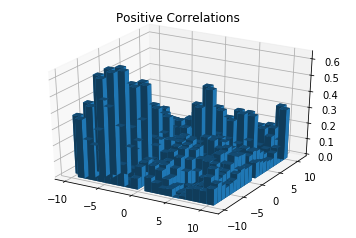

In [10]:
xs = []
ys = []
dx = 1
dy = 1
dz = []
for k1 in range(-K,K+1):
    if k1 != 0:
        for k2 in range(-K,K+1):
            if k2 != 0:
                if k1 != k2:
                    xs.append(k1)
                    ys.append(k2)
                    dz.append(pos_pos_correlations[k1][k2])
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.title("Positive Correlations")
plt.show()

In [11]:
pos_neg_correlations = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_neg_correlations[i][j] = np.corrcoef(positive_updates[i], negative_updates[j])[0][1]
pos_neg_correlations_styled = pos_neg_correlations.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_neg_correlations_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,0.667,0.353,0.273,0.221,0.204,0.173,0.149,0.172,0.105,0.116,0.118,0.116,0.085,0.083,0.028,0.051,0.092,0.103,0.116,0.097
-9,0.338,0.833,0.433,0.285,0.225,0.173,0.149,0.142,0.116,0.147,0.125,0.145,0.110,0.077,0.040,0.043,0.073,0.099,0.163,0.116
-8,0.224,0.450,0.906,0.594,0.425,0.249,0.179,0.182,0.088,0.163,0.137,0.159,0.103,0.048,0.017,0.037,0.063,0.092,0.165,0.085
-7,0.214,0.290,0.604,0.961,0.625,0.312,0.151,0.174,0.051,0.160,0.126,0.158,0.126,0.029,0.028,-0.016,0.025,0.115,0.122,0.068
-6,0.190,0.227,0.435,0.623,0.965,0.638,0.297,0.211,0.038,0.139,0.173,0.205,0.181,0.096,0.007,-0.007,0.033,0.106,0.118,0.074
-5,0.160,0.173,0.267,0.318,0.639,0.971,0.547,0.352,0.154,0.222,0.246,0.233,0.232,0.172,0.109,0.081,0.087,0.104,0.142,0.087
-4,0.136,0.142,0.200,0.156,0.293,0.538,0.968,0.540,0.234,0.237,0.228,0.242,0.236,0.210,0.161,0.163,0.150,0.114,0.162,0.111
-3,0.144,0.150,0.226,0.190,0.236,0.347,0.554,0.968,0.422,0.258,0.245,0.271,0.250,0.215,0.135,0.143,0.194,0.148,0.209,0.122
-2,0.083,0.141,0.143,0.098,0.101,0.198,0.295,0.491,0.948,0.391,0.263,0.232,0.199,0.169,0.157,0.177,0.212,0.140,0.201,0.115
-1,0.089,0.127,0.167,0.159,0.175,0.221,0.229,0.255,0.312,0.903,0.297,0.162,0.136,0.196,0.189,0.138,0.137,0.097,0.131,0.096


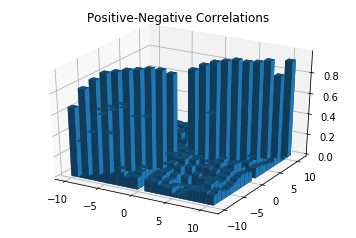

In [12]:
xs = []
ys = []
dx = 1
dy = 1
dz = []
for k1 in range(-K,K+1):
    if k1 != 0:
        for k2 in range(-K,K+1):
            if k2 != 0:
                xs.append(k1)
                ys.append(k2)
                dz.append(pos_neg_correlations[k1][k2])
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.title("Positive-Negative Correlations")
plt.show()

In [13]:
df = pd.DataFrame(negative_updates)
neg_neg_correlations = df.corr().astype('object')
neg_neg_correlations_styled = neg_neg_correlations.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
neg_neg_correlations_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.364,0.265,0.227,0.198,0.178,0.158,0.185,0.132,0.112,0.095,0.134,0.095,0.079,0.023,0.053,0.107,0.111,0.136,0.091
-9,0.364,1.000,0.469,0.278,0.225,0.184,0.164,0.152,0.140,0.117,0.148,0.172,0.112,0.075,0.033,0.042,0.088,0.094,0.159,0.098
-8,0.265,0.469,1.000,0.601,0.421,0.260,0.183,0.192,0.128,0.159,0.132,0.185,0.107,0.048,0.011,0.036,0.071,0.102,0.176,0.068
-7,0.227,0.278,0.601,1.000,0.618,0.315,0.149,0.179,0.099,0.161,0.102,0.175,0.125,0.030,0.026,-0.011,0.041,0.135,0.149,0.055
-6,0.198,0.225,0.421,0.618,1.000,0.646,0.288,0.216,0.084,0.161,0.135,0.229,0.181,0.096,0.006,-0.004,0.052,0.129,0.162,0.073
-5,0.178,0.184,0.260,0.315,0.646,1.000,0.552,0.353,0.208,0.220,0.206,0.262,0.239,0.173,0.105,0.081,0.099,0.119,0.166,0.084
-4,0.158,0.164,0.183,0.149,0.288,0.552,1.000,0.548,0.292,0.221,0.198,0.273,0.248,0.217,0.158,0.162,0.152,0.124,0.176,0.107
-3,0.185,0.152,0.192,0.179,0.216,0.353,0.548,1.000,0.506,0.252,0.190,0.292,0.264,0.223,0.133,0.151,0.210,0.167,0.224,0.114
-2,0.132,0.140,0.128,0.099,0.084,0.208,0.292,0.506,1.000,0.371,0.229,0.243,0.217,0.173,0.152,0.185,0.224,0.151,0.189,0.105
-1,0.112,0.117,0.159,0.161,0.161,0.220,0.221,0.252,0.371,1.000,0.252,0.159,0.143,0.191,0.193,0.157,0.170,0.117,0.149,0.093


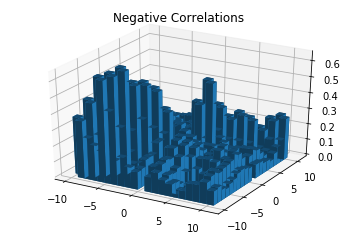

In [14]:
xs = []
ys = []
dx = 1
dy = 1
dz = []
for k1 in range(-K,K+1):
    if k1 != 0:
        for k2 in range(-K,K+1):
            if k2 != 0:
                if k1 != k2:
                    xs.append(k1)
                    ys.append(k2)
                    dz.append(neg_neg_correlations[k1][k2])
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.title("Negative Correlations")
plt.show()

# Find Average Event Sizes and Average Rate

In [15]:
K = 10
def AES_and_Rate(updates, starting_times):
    event_sizes_pos = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
    event_sizes_neg = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
    
    for updates in all_updates:
        for u in updates:
            if u['change'] > 0:
                event_sizes_pos[u['k']].append(u['change'])
            else:
                event_sizes_neg[u['k']].append(-u['change'])
                
    total_time = np.sum([(e-s).total_seconds() for s,e in zip(starting_times,ending_times)])
                
    AESs = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                       [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    numbers_of_events = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                                   [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    average_rates = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                                [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    
    for (k,sizes) in event_sizes_pos.items():
        AESs[(k,"pos")] = np.mean(sizes)
        numbers_of_events[(k,"pos")] = len(sizes)
        
    for (k,sizes) in event_sizes_neg.items():
        AESs[(k,"neg")] = np.mean(sizes)
        numbers_of_events[(k,"neg")] = len(sizes)
        
    for k in numbers_of_events:
        average_rates[k] = numbers_of_events[k] / total_time
        
    return AESs, numbers_of_events, average_rates
            

AESs, numbers_of_events, average_rates = AES_and_Rate(all_updates, starting_times)

for k in range(-K,K+1):
    if k != 0:
        print("k = {}".format(k))
        print("AES Positive: {}".format(AESs[(k,"pos")]))
        print("Average Rate: {}".format(average_rates[(k,"pos")]))
        print("Multiplied: {}".format(AESs[(k,"pos")]*average_rates[(k,"pos")]))
        print("AES Negative: {}".format(AESs[(k,"neg")]))
        print("Average Rate: {}".format(average_rates[(k,"neg")]))
        print("Multiplied: {}".format(AESs[(k,"neg")]*average_rates[(k,"neg")]))
        print()

k = -10
AES Positive: 601.4124541063055
Average Rate: 0.0015663206844764182
Multiplied: 0.9420047667684309
AES Negative: 597.758153757424
Average Rate: 0.0019019608311499365
Multiplied: 1.1369125949471217

k = -9
AES Positive: 479.6863613652646
Average Rate: 0.0026966949715493014
Multiplied: 1.29356779861449
AES Negative: 446.5999332116102
Average Rate: 0.002851012280364712
Multiplied: 1.273261893996361

k = -8
AES Positive: 584.5728342409202
Average Rate: 0.005995227447478704
Multiplied: 3.5046471008915834
AES Negative: 552.6849764006743
Average Rate: 0.006180408218057197
Multiplied: 3.4158187701434755

k = -7
AES Positive: 530.3406793258122
Average Rate: 0.021731735013930206
Multiplied: 11.525223110216285
AES Negative: 534.065776466186
Average Rate: 0.020898421546326987
Multiplied: 11.161131730056793

k = -6
AES Positive: 520.9486674717087
Average Rate: 0.050596787627852774
Multiplied: 26.358329093078943
AES Negative: 531.856717471623
Average Rate: 0.049582151322391445
Multiplied: 26

In [16]:
AESs_vector = []
average_rates_vector = []
for k in range(-K,K+1):
    if k != 0:
        AESs_vector.append(AESs[(k,"pos")])
        average_rates_vector.append(average_rates[(k,"pos")])
for k in range(-K,K+1):
    if k != 0:
        AESs_vector.append(AESs[(k,"neg")])
        average_rates_vector.append(average_rates[(k,"neg")])

In [17]:
def inverse_PDF_Poisson(average, u):
    x = 0
    p = np.exp(-average)
    s = p
    while u > s:
        x += 1
        p = p * average / x
        s = s + p
    return x  

def arrivals_during_time_period(AESs, average_rates, correlations, start_time, T):
    correlated_normals = np.random.multivariate_normal(mean=[0 for _ in AESs], cov=correlations)
    us = [norm.cdf(y) for y in correlated_normals]
    num_arrivals = [inverse_PDF_Poisson(rate*T,u) for (rate,u) in zip(average_rates,us)]
    labels = [(k,"pos") for k in range(-K,K+1) if k != 0] + [(k,"neg") for k in range(-K,K+1) if k != 0]
    events = []
    for i,n in enumerate(num_arrivals):
        position, direction = labels[i]
        for _ in range(n):
            arrival_time = start_time + np.random.uniform()*T
            arrival_size = min(np.random.exponential(AESs[i]),5000)
            if direction == "neg":
                arrival_size *= -1
            events.append((arrival_time, arrival_size, position, False))
    return events        

In [18]:
events = arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, 0, 60)
events

[(25.791558584101097, 103.11427807731782, -7, False),
 (14.431366619065402, 277.42755775595015, -6, False),
 (38.44686244691326, 670.7085493213531, -6, False),
 (53.47695258585429, 406.23050861733986, -5, False),
 (0.5014789076359527, 122.425425052609, -5, False),
 (27.7545231745303, 323.3399090868609, -5, False),
 (57.642155684334234, 505.7038103044733, -5, False),
 (51.09892138282215, 420.9539045523383, -5, False),
 (25.14777972251627, 480.62253680664486, -4, False),
 (32.83102476125589, 166.76828770998426, -4, False),
 (53.999420760773056, 0.24920260786912257, -4, False),
 (16.67615633291756, 734.5886681775542, -4, False),
 (4.102580371609226, 22.624073379868992, -3, False),
 (28.000796636787577, 702.9016367203111, -3, False),
 (5.52804441642315, 444.2706842767693, -3, False),
 (28.134217274594683, 161.9240285100204, -3, False),
 (20.112977402627276, 66.19611909956492, -3, False),
 (40.86484322528748, 7.05706192016494, -2, False),
 (44.55330117784337, 95.09831195413092, -2, False),


# Plot Events

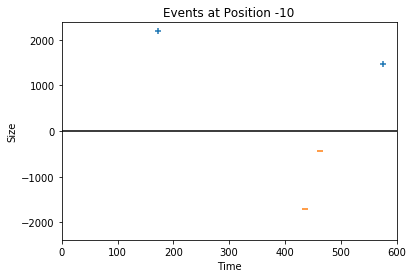

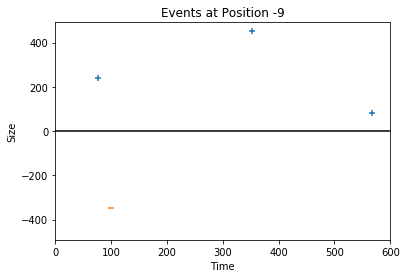

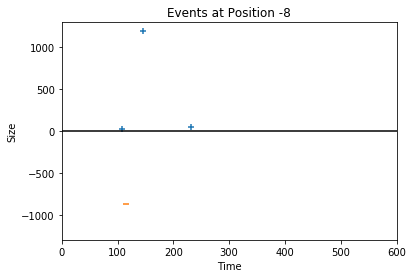

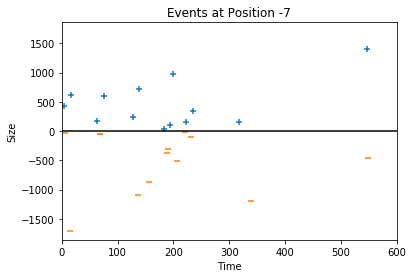

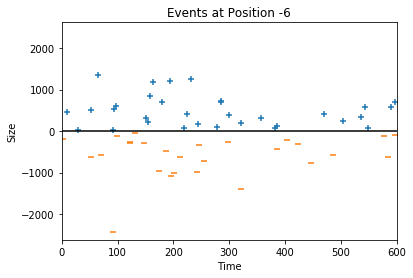

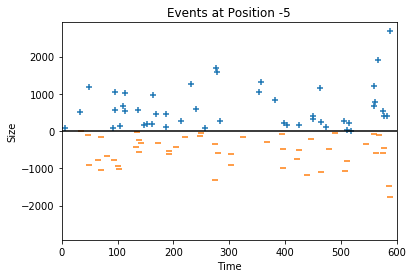

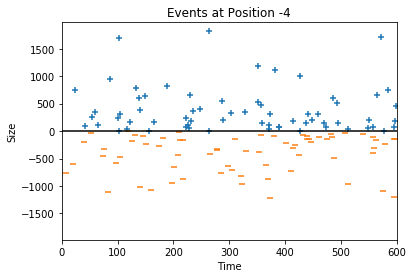

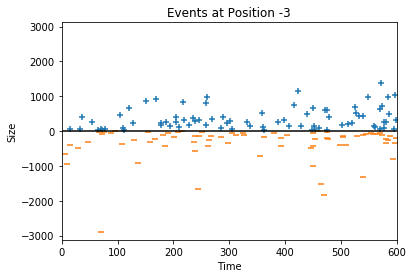

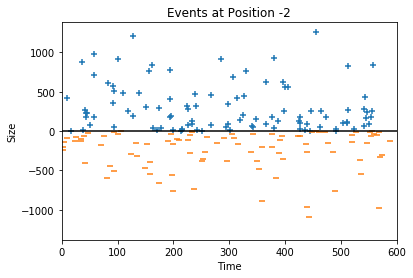

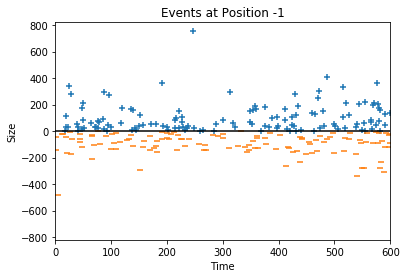

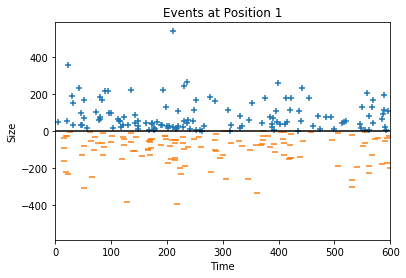

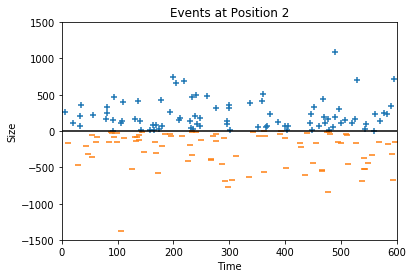

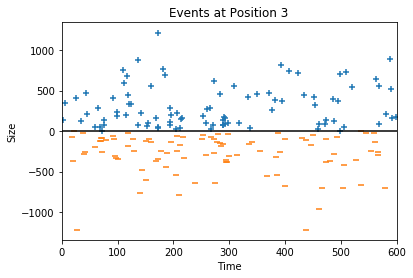

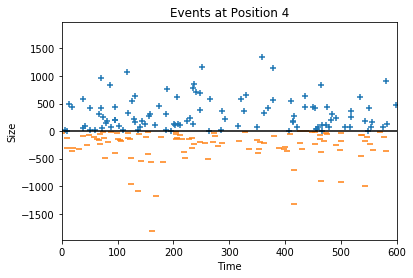

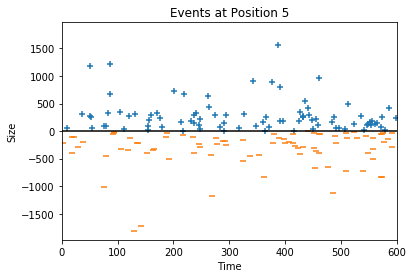

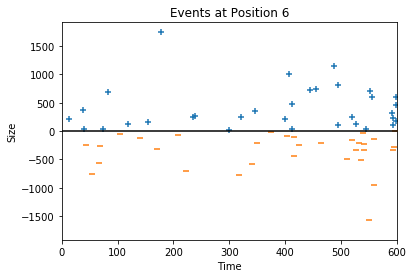

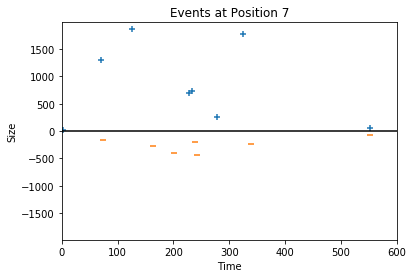

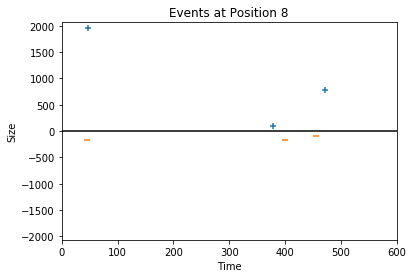

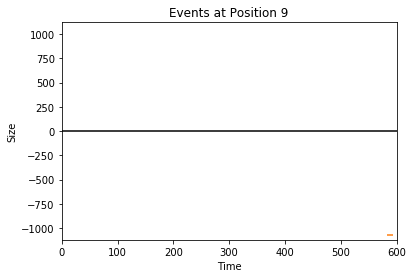

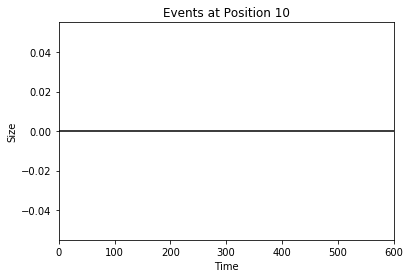

In [19]:
events = [arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, i*60, 60) for i in range(10)]
events = [e for es in events for e in es]

for k in range(-K,K+1):
    if k != 0:
        events_at_k = [(e[0],e[1]) for e in events if e[2] == k]
        positive_events = [e for e in events_at_k if e[1] > 0]
        if len(positive_events) > 0:
            positive_times, positive_sizes = zip(*positive_events)
        else:
            positive_times, positive_sizes = [],[]
        negative_events = [e for e in events_at_k if e[1] < 0]
        if len(negative_events) > 0:
            negative_times, negative_sizes = zip(*negative_events)
        else:
            negative_times, negative_sizes = [],[]
        plt.scatter(positive_times, positive_sizes, marker="+")
        plt.scatter(negative_times, negative_sizes, marker="_")
        plt.axhline(0,color='k')
        plt.xlim([0, 600])
        plt.xlabel("Time")
        plt.ylabel("Size")
        lower, upper = plt.gca().get_ylim()
        lim = max(abs(lower),abs(upper))
        plt.ylim([-lim,lim])
        plt.title("Events at Position {}".format(k))
        plt.show()
        
plt.close()

# Simulated Correlation

In [20]:
def num_arrivals_during_time_period(AESs, average_rates, correlations, start_time, T):
    correlated_normals = np.random.multivariate_normal(mean=[0 for _ in AESs], cov=correlations)
    us = [norm.cdf(y) for y in correlated_normals]
    num_arrivals = [inverse_PDF_Poisson(rate*T,u) for (rate,u) in zip(average_rates,us)]
    return num_arrivals

In [21]:
n = 10000
trials = [num_arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, 0, 60) for _ in range(n)]

In [22]:
simulated_correlations = np.corrcoef(trials,rowvar=False)

In [23]:
indices = {}
i = 0
for k in range(-K,K+1):
    if k != 0:
        indices[(k,"pos")] = i
        i += 1
for k in range(-K,K+1):
    if k != 0:
        indices[(k,"neg")] = i
        i += 1
        
pos_pos_correlations_simulated = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_pos_correlations_simulated[i][j] = simulated_correlations[indices[(i,"pos")]][indices[(j,"pos")]]
pos_pos_correlations_simulated_styled = \
    pos_pos_correlations_simulated.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_pos_correlations_simulated_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.174,0.148,0.138,0.133,0.108,0.082,0.081,0.026,0.044,0.047,0.030,0.041,0.037,-0.015,-0.011,0.041,0.045,0.008,0.048
-9,0.174,1.000,0.278,0.213,0.161,0.098,0.080,0.099,0.083,0.101,0.093,0.082,0.060,0.045,0.015,0.019,0.047,0.069,0.067,0.039
-8,0.148,0.278,1.000,0.508,0.361,0.197,0.147,0.158,0.075,0.106,0.104,0.111,0.060,0.032,0.009,0.004,0.040,0.048,0.101,0.052
-7,0.138,0.213,0.508,1.000,0.595,0.284,0.131,0.155,0.028,0.121,0.111,0.148,0.117,0.021,0.017,-0.039,0.037,0.067,0.048,0.043
-6,0.133,0.161,0.361,0.595,1.000,0.610,0.274,0.198,0.031,0.120,0.164,0.198,0.167,0.083,0.001,-0.036,0.044,0.071,0.046,0.044
-5,0.108,0.098,0.197,0.284,0.610,1.000,0.516,0.321,0.126,0.187,0.226,0.211,0.216,0.140,0.092,0.043,0.048,0.069,0.075,0.044
-4,0.082,0.080,0.147,0.131,0.274,0.516,1.000,0.536,0.223,0.221,0.222,0.236,0.225,0.192,0.158,0.139,0.118,0.086,0.096,0.067
-3,0.081,0.099,0.158,0.155,0.198,0.321,0.536,1.000,0.398,0.239,0.220,0.257,0.240,0.191,0.125,0.134,0.168,0.106,0.124,0.082
-2,0.026,0.083,0.075,0.028,0.031,0.126,0.223,0.398,1.000,0.336,0.214,0.214,0.168,0.133,0.123,0.143,0.169,0.095,0.103,0.067
-1,0.044,0.101,0.106,0.121,0.120,0.187,0.221,0.239,0.336,1.000,0.265,0.200,0.202,0.223,0.229,0.161,0.172,0.099,0.099,0.062


In [24]:
pos_neg_correlations_simulated = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_neg_correlations_simulated[i][j] = simulated_correlations[indices[(i,"pos")]][indices[(j,"neg")]]
pos_neg_correlations_simulated_styled = \
    pos_neg_correlations_simulated.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_neg_correlations_simulated_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,0.407,0.171,0.168,0.148,0.138,0.107,0.098,0.105,0.044,0.061,0.069,0.058,0.054,0.060,0.025,0.007,0.049,0.055,0.056,0.031
-9,0.155,0.622,0.263,0.202,0.160,0.117,0.111,0.105,0.088,0.119,0.068,0.082,0.081,0.066,0.032,0.030,0.056,0.061,0.074,0.044
-8,0.134,0.288,0.774,0.506,0.345,0.191,0.146,0.139,0.073,0.131,0.096,0.129,0.087,0.044,0.010,0.012,0.044,0.051,0.088,0.045
-7,0.130,0.197,0.515,0.909,0.587,0.282,0.130,0.149,0.033,0.143,0.105,0.147,0.120,0.027,0.027,-0.032,0.036,0.073,0.060,0.046
-6,0.130,0.153,0.356,0.582,0.939,0.616,0.273,0.185,0.026,0.124,0.149,0.194,0.169,0.082,0.004,-0.028,0.041,0.072,0.046,0.041
-5,0.111,0.105,0.203,0.287,0.616,0.955,0.529,0.335,0.141,0.211,0.222,0.226,0.236,0.162,0.114,0.070,0.068,0.081,0.078,0.054
-4,0.084,0.086,0.148,0.132,0.266,0.520,0.955,0.538,0.230,0.231,0.221,0.243,0.238,0.199,0.167,0.163,0.132,0.092,0.104,0.069
-3,0.082,0.107,0.163,0.157,0.206,0.323,0.552,0.957,0.424,0.251,0.230,0.274,0.250,0.201,0.129,0.137,0.183,0.120,0.132,0.088
-2,0.049,0.107,0.115,0.081,0.088,0.182,0.289,0.495,0.941,0.389,0.257,0.241,0.202,0.164,0.154,0.165,0.203,0.109,0.122,0.077
-1,0.058,0.107,0.129,0.140,0.168,0.212,0.220,0.240,0.309,0.893,0.290,0.150,0.138,0.180,0.197,0.109,0.121,0.064,0.069,0.058


In [25]:
neg_neg_correlations_simulated = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            neg_neg_correlations_simulated[i][j] = simulated_correlations[indices[(i,"neg")]][indices[(j,"neg")]]
neg_neg_correlations_simulated_styled = \
    neg_neg_correlations_simulated.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
neg_neg_correlations_simulated_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.196,0.167,0.147,0.134,0.108,0.101,0.110,0.062,0.069,0.048,0.074,0.059,0.056,0.021,0.017,0.060,0.060,0.067,0.025
-9,0.196,1.000,0.301,0.194,0.162,0.128,0.115,0.112,0.108,0.095,0.080,0.105,0.081,0.064,0.025,0.035,0.067,0.059,0.058,0.046
-8,0.167,0.301,1.000,0.510,0.345,0.201,0.145,0.143,0.103,0.125,0.087,0.145,0.092,0.041,0.004,0.016,0.045,0.070,0.105,0.027
-7,0.147,0.194,0.510,1.000,0.573,0.283,0.127,0.151,0.082,0.147,0.076,0.161,0.121,0.025,0.026,-0.020,0.048,0.100,0.088,0.025
-6,0.134,0.162,0.345,0.573,1.000,0.625,0.265,0.190,0.071,0.151,0.107,0.220,0.173,0.081,0.003,-0.019,0.052,0.095,0.082,0.030
-5,0.108,0.128,0.201,0.283,0.625,1.000,0.533,0.336,0.193,0.210,0.180,0.254,0.242,0.162,0.112,0.073,0.079,0.089,0.092,0.028
-4,0.101,0.115,0.145,0.127,0.265,0.533,1.000,0.546,0.289,0.210,0.189,0.276,0.250,0.207,0.164,0.165,0.131,0.099,0.106,0.046
-3,0.110,0.112,0.143,0.151,0.190,0.336,0.546,1.000,0.511,0.239,0.179,0.301,0.264,0.208,0.125,0.146,0.195,0.137,0.140,0.071
-2,0.062,0.108,0.103,0.082,0.071,0.193,0.289,0.511,1.000,0.366,0.223,0.254,0.217,0.169,0.145,0.173,0.213,0.117,0.110,0.053
-1,0.069,0.095,0.125,0.147,0.151,0.210,0.210,0.239,0.366,1.000,0.243,0.151,0.144,0.175,0.199,0.134,0.160,0.078,0.085,0.047


In [26]:
averages = []
for i in range(4*K):
    averages.append(np.mean([t[i] for t in trials])/60)
averages

[0.0016016666666666668,
 0.0028066666666666665,
 0.006121666666666667,
 0.02216,
 0.050734999999999995,
 0.08441333333333333,
 0.10676166666666667,
 0.12820333333333334,
 0.18202333333333334,
 0.20920333333333332,
 0.18627666666666667,
 0.14497,
 0.15980166666666668,
 0.17287,
 0.145795,
 0.06277333333333333,
 0.01444,
 0.004815,
 0.0023000000000000004,
 0.0020700000000000002,
 0.0019733333333333334,
 0.0028866666666666667,
 0.006265000000000001,
 0.021131666666666667,
 0.049828333333333336,
 0.08449833333333333,
 0.10660666666666667,
 0.128225,
 0.17402833333333334,
 0.18971833333333335,
 0.1806583333333333,
 0.14739166666666667,
 0.16175333333333333,
 0.171645,
 0.142925,
 0.06036166666666667,
 0.013921666666666667,
 0.004931666666666667,
 0.0020916666666666666,
 0.002]

# Find Average Size at Each Position

In [27]:
total_time = sum([(e-s).total_seconds() for s,e in zip(starting_times, ending_times)])
weighted_sums = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
average_price = 0
for i in range(len(all_updates)):
    prev_time = starting_times[i]
    for u in all_updates[i]:
        t = u['time']
        for k in range(-K,K+1):
            if k != 0:
                weighted_sums[k] += u['LOB'][k] * (t - prev_time).total_seconds()
        average_price += u['reference_price'] * (t - prev_time).total_seconds()
        prev_time = t
        
    last_LOB = copy.deepcopy(all_updates[i][-1]['LOB'])
    last_LOB[all_updates[i][-1]['k']] += all_updates[i][-1]['change']
    for k in range(1,K+1):
        if last_LOB[k] > 0:
            first_ask_price = round(all_updates[i][-1]['reference_price'] - 0.5 + k)
            break
    for k in reversed(range(-K,0)):
        if last_LOB[k] > 0:
            first_bid_price = round(all_updates[i][-1]['reference_price'] + 0.5 + k)
            break
    if (first_ask_price - first_bid_price) % 2 != 0:
        last_ref_price = round(float(first_ask_price + first_bid_price) / 2,1)
    else:
        middle_price = round((first_ask_price + first_bid_price)/2)
        if middle_price < ref_price:
            last_ref_price = round(middle_price + 0.5, 1)
        else:
            last_ref_price = round(middle_price - 0.5, 1)
            
    for k in range(-K,K+1):
        if k != 0:
            weighted_sums[k] += last_LOB[k]*(ending_times[i] - all_updates[i][-1]['time']).total_seconds()
    average_price += last_ref_price * (ending_times[i] - all_updates[i][-1]['time']).total_seconds()
            
average_sizes = copy.deepcopy(weighted_sums)
for k in range(-K,K+1):
    if k != 0:
        average_sizes[k] = weighted_sums[k] / total_time
        
average_price = average_price / total_time
    
print("Average price: {}".format(average_price))
print("Average Sizes:")
average_sizes

Average price: 516.9074565838985
Average Sizes:


OrderedDict([(-10, 287.1343261066107),
             (-9, 250.14440598382774),
             (-8, 292.8595557315305),
             (-7, 609.8154879314532),
             (-6, 1338.8977034506945),
             (-5, 2578.2647828454283),
             (-4, 2735.4364300829075),
             (-3, 2328.270135971142),
             (-2, 1425.6754816026087),
             (-1, 587.9266763538596),
             (1, 495.78529919956264),
             (2, 983.2351859382003),
             (3, 1475.5901257103164),
             (4, 2170.5963486266273),
             (5, 2456.864847931035),
             (6, 1807.15589047753),
             (7, 817.156989876897),
             (8, 420.6087178769215),
             (9, 404.1115441720219),
             (10, 390.98856591945906)])

# Simulation

In [28]:
def simulate(starting_ref_price, starting_book, starting_time, num_intervals, T, A, market_orders, rates=None):
    ref_price = starting_ref_price
    sizes = copy.copy(starting_book)
    interval_start = starting_time
    
    # Find the market orders in each interval
    orders_in_interval = OrderedDict([(i,[]) for i in range(num_intervals)])
    i = 0
    for order in market_orders:
        if order[0] > starting_time + (i+1)*T:
            i += 1
        orders_in_interval[i].append(order)
            
    # Amount left to buy
    a = A
    
    # Prices and amounts
    filled_orders = []
    
    
    for n in range(num_intervals):       
        interval_start = n*T
        if rates == None:
            events = arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, interval_start, T)
        else:
            events = arrivals_during_time_period(AESs_vector, rates[n], sigma, interval_start, T)
        orders = [(t,-size,1,True) for (t,size) in orders_in_interval[n]]
        # Finish ordering all that is left
        if n == (num_intervals-1) and a > 0:
            orders.append(((n+1)*T,-a,1,True))
        all_events = sorted(events + orders, key=lambda x: x[0])
        
        for (t,change,k,is_order) in all_events:
            
            if False:
                print("Interval: {}".format(n + 1))
                print("Ref price: {}".format(ref_price))
                for x in sizes:
                    if abs(ref_price - x) < K:
                        print("{}: {}".format(x,sizes[x]))
                print("Event: time = {}, k = {}, change = {}, order = {}".format(t,k,change,is_order))
                print()
                print()
                
            if is_order:
                left_to_fill = min(-change,a)
                p = round(ref_price + 0.5)
                while p < 617 and sizes[p] < left_to_fill:
                    if sizes[p] > 0:
                        filled_orders.append((t,p,sizes[p]))
                    left_to_fill -= sizes[p]
                    sizes[p] = 0
                    p += 1
                if left_to_fill > 0:
                    filled_orders.append((t,p,left_to_fill))
                sizes[p] = max(0,sizes[p] - left_to_fill)
                left_to_fill = 0
                
                a = max(0, a + change)
            
            else:    
                # Negative event
                if change < 0:
                    # Check if first:
                    if k < 0:
                        price = round(ref_price + 0.5 + k)
                        is_first = True
                        for p in reversed(range(price + 1,round(ref_price + 0.5))):
                            if sizes[p] > 0:
                                is_first = False

                        # If first, go down prices
                        if is_first:
                            p = price
                            amount_left = -change
                            while i > 0 and sizes[p] < amount_left:
                                amount_left -= sizes[p]
                                sizes[p] = 0
                                p -= 1
                            sizes[p] = max(0, sizes[p] - amount_left)
                        # Otherwise, just subtract
                        else:
                            sizes[price] = max(0, sizes[price] + change) 

                    else:
                        price = round(ref_price - 0.5 + k)
                        is_first = True
                        for p in range(round(ref_price + 0.5),price):
                            if sizes[p] > 0:
                                is_first = False

                        # If first, go down prices
                        if is_first:
                            p = price
                            amount_left = -change
                            while p < 1017 and sizes[p] < amount_left:
                                amount_left -= sizes[p]
                                sizes[p] = 0
                                p += 1
                            sizes[p] = max(0, sizes[p] - amount_left)
                        else:
                            sizes[price] = max(0, sizes[price] + change)

                # Positive events
                else:
                    if k < 0:
                        price = round(ref_price + 0.5 + k)
                    else:
                        price = round(ref_price - 0.5 + k)
                    sizes[price] += change
                
            # Update ref price
            for p in range(round(ref_price + 0.5),1017):
                if sizes[p] != 0:
                    first_ask_price = p
                    break
            for p in reversed(range(0,round(ref_price + 0.5))):
                if sizes[p] != 0:
                    first_bid_price = p
                    break
        
            if (first_ask_price - first_bid_price) % 2 != 0:
                ref_price = round(float(first_ask_price + first_bid_price) / 2,1)
            else:
                middle_price = round((first_ask_price + first_bid_price)/2)
                if middle_price < ref_price:
                    ref_price = round(middle_price + 0.5, 1)
                else:
                    ref_price = round(middle_price - 0.5, 1)
                    
    return filled_orders

In [30]:
starting_sizes = copy.deepcopy(average_sizes)

average_price = 516.5

starting_book = OrderedDict()
for i in range(0,round(average_price + 0.5 - K)):
    starting_book[i] = 100
for k in range(-K,0):
    starting_book[round(average_price+0.5+k)] = starting_sizes[k]
for k in range(1,K+1):
    starting_book[round(average_price-0.5+k)] = starting_sizes[k]
for i in range(round(average_price + 0.5 + K), round(average_price + 0.5 + 500)):
    starting_book[i] = 100

In [32]:
def vwap(filled_orders):
    weighted_sum = 0
    total_amount = 0
    for order in filled_orders:
        weighted_sum += order[1]*order[2]
        total_amount += order[2]
    return weighted_sum / total_amount

In [33]:
orders = simulate(average_price, starting_book, 0, 5, 60, 8000, [(1,2000),(61,2000),(121,2000),(181,1000)])
print("VWAP: {}".format(vwap(orders)))
orders

VWAP: 519.7297122785611


[(1, 517, 495.78529919956264),
 (1, 518, 983.2351859382003),
 (1, 519, 520.9795148622371),
 (61, 518, 125.93851784906384),
 (61, 519, 1320.6485767835143),
 (61, 520, 469.3613495297631),
 (61, 521, 84.05155583765878),
 (121, 520, 809.2706172802376),
 (121, 521, 1190.7293827197623),
 (181, 521, 448.1128953335089),
 (181, 522, 551.887104666491),
 (300, 520, 441.6384179156771),
 (300, 521, 558.3615820843229)]

In [34]:
orders = simulate(516.5, starting_book, 0, 5, 60, 8000, [(150,1000)])
print("VWAP: {}".format(vwap(orders)))
orders

VWAP: 520.3581390719912


[(150, 517, 815.6737612101111),
 (150, 518, 184.32623878988886),
 (300, 518, 176.03643591752882),
 (300, 519, 623.1916240558674),
 (300, 520, 1493.7899368865467),
 (300, 521, 2757.913173249232),
 (300, 522, 1949.0688298908249)]

In [35]:
def simulate_split(num_minutes, A, num_trades):
    order_size = A / num_trades
    market_orders = []
    for i in range(1,num_trades+1):
        market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size))
    orders = simulate(average_price, starting_book, 0, num_minutes, 60, A, market_orders)
    return vwap(orders)

In [36]:
n = 1000
A = 20000
minutes = 10

In [37]:
vwaps = []

In [38]:
vwaps.append([simulate_split(minutes,A,1) for _ in range(n)])

In [39]:
vwaps_2 = []
for i in range(n):
    vwaps_2.append(simulate_split(minutes,A,2))
    if i % 500 == 0:
        print(i)
vwaps.append(vwaps_2)

0
500


In [40]:
vwaps_3 = []
for i in range(n):
    vwaps_3.append(simulate_split(minutes,A,3))
    if i % 500 == 0:
        print(i)
vwaps.append(vwaps_3)

0
500


In [41]:
vwaps_4 = []
for i in range(n):
    vwaps_4.append(simulate_split(minutes,A,4))
    if i % 500 == 0:
        print(i)
vwaps.append(vwaps_4)

0
500


In [42]:
vwaps_5 = []
for i in range(n):
    vwaps_5.append(simulate_split(minutes,A,5))
    if i % 1000 == 0:
        print(i)
vwaps.append(vwaps_5)

0


In [418]:
vwaps_6 = []
for i in range(n):
    vwaps_6.append(simulate_split(minutes,A,6))
    if i % 1000 == 0:
        print(i)
vwaps.append(vwaps_6)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [419]:
vwaps_7 = []
for i in range(n):
    vwaps_7.append(simulate_split(minutes,A,7))
    if i % 1000 == 0:
        print(i)
vwaps.append(vwaps_7)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [421]:
vwaps_8 = []
for i in range(n):
    vwaps_8.append(simulate_split(minutes,A,8))
    if i % 1000 == 0:
        print(i)
vwaps.append(vwaps_8)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [428]:
vwaps_9 = []
for i in range(n):
    vwaps_9.append(simulate_split(minutes,A,9))
    if i % 1000 == 0:
        print(i)
vwaps.append(vwaps_9)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [429]:
vwaps_10 = []
for i in range(n):
    vwaps_10.append(simulate_split(minutes,A,10))
    if i % 1000 == 0:
        print(i)
vwaps.append(vwaps_10)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [ ]:
vwaps_100 = []
for i in range(n):
    vwaps_100.append(simulate_split(minutes,A,100))
    if i % 1000 == 0:
        print(i)

In [43]:
for i in range(1,6):
    print("Split at {}".format(i))
    print("Mean = {}, Variance = {}".format(np.mean(vwaps[i-1]),np.var(vwaps[i-1])))

Split at 1
Mean = 535.2857171416932, Variance = 133.30441026299349
Split at 2
Mean = 526.534948847139, Variance = 56.754233846890024
Split at 3
Mean = 523.4090290647151, Variance = 22.89352626319854
Split at 4
Mean = 522.2838470096917, Variance = 12.875246926244822
Split at 5
Mean = 521.6001776003701, Variance = 5.2424673111311755


In [77]:
def simulate_split_2rates(num_minutes, A, num_trades, first_half_market_activity, first_half_trade_activity):
    order_size_average = A / num_trades
    order_size_first_half = order_size_average * first_half_trade_activity / 0.5
    order_size_second_half = order_size_average * (1 - first_half_trade_activity) / 0.5
    
    market_orders = []
    for i in range(1,num_trades+1):
        if i <= num_trades / 2:
            market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size_first_half))
        else:
            market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size_second_half))
            
    first_half_rates = [r*first_half_market_activity/0.5 for r in average_rates_vector]
    second_half_rates = [r*(1-first_half_market_activity)/0.5 for r in average_rates_vector]

    rates = OrderedDict([(n,None) for n in range(num_minutes)])
    for n in range(num_minutes):
        if n < num_minutes / 2:
            rates[n] = first_half_rates
        else:
            rates[n] = second_half_rates
            
    orders = simulate(average_price, starting_book, 0, num_minutes, 60, A, market_orders,rates=rates)
    return vwap(orders)

In [78]:
simulate_split_2rates(10,A,20,0.75,.75)

521.504517069346

In [101]:
trials_with_vwap = [simulate_split_2rates(10,40000,12,0.8,0.8) for _ in range(500)]
trials_without_vwap = [simulate_split_2rates(10,40000,12,0.8,0.5) for _ in range(500)]

In [102]:
np.mean(trials_with_vwap)

528.309224986887

In [103]:
np.mean(trials_without_vwap)

529.2841224116927

In [104]:
np.var(trials_with_vwap)

53.6147026235488

In [105]:
np.var(trials_without_vwap)

50.69612004882763